## Corrio SPC Segmentation & Usage Behavior Analysis

In this analysis, we clean and segment Corrio SPC user activity, derive aggregated usage metrics per user account, and apply k-means clustering to segment the users. We then analyze each segment's usage behavior to understand how they differ. The steps include:  
* **Cleaning and standardizing the dataset** – (combining multiple raw log files and fixing data types)  
- **Computing aggregate usage metrics per account** – (total events, active days, revenue, etc.)  
- **Segmenting users via k-means clustering** – (group accounts based on usage metrics)  
- **Examining each user segment's characteristics** – (usage patterns, revenue contributions, engagement duration)


### Table of Contents
- **Phase 0:** Library Imports  
- **Phase 1:** Cleaning and Standardizing Dataset  
    - Step 1.1: Importing event logs and initial cleaning  
    - Step 1.2: Aggregating data into per-account metrics  
    - Step 1.3: Exploratory charts of core metrics  
- **Phase 2:** K-Means Clustering Trials  
    - Step 2.1: Selecting behavior features & feature scaling  
    - Step 2.2: Determining optimal k with the elbow method  
    - Step 2.3: Applying k-means and basic cluster metrics  
    - Step 2.4: Analyzing revenue distribution by cluster  
    - Step 2.5: PCA for dimensionality reduction (cluster validation)  
    - Step 2.6: Visualizing clusters in PCA space  
- **Phase 3:** Other Graphs & Metrics

## Phase 0: Library Imports

In this section, we import the necessary Python libraries for data analysis. We use standard data manipulation and visualization libraries (pandas, numpy, matplotlib, seaborn), as well as scikit-learn for clustering (KMeans) and dimensionality reductgion (PCA) These tools provide the functionality for cleaning data, computing statistis, clustering observations, and visualizing results. 

In [1]:
import glob
from collections import defaultdict
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#Addition to matplot: adds boxplots, violin plots, bar plots, histograms, kernel density estimation plots, scatter plots, and line plots
import seaborn as sns

from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats

#We can't get datetime from Galactus, because EKS still doens't have their shit together...
from datetime import timedelta

## Phase 1: Importing, Cleaning, and Standardizing Dataset

In Phase 1, we load the raw event log data from Corrio SPC, perform cleaning and preprocessing, and transform the raw event records into a consolidated dataset of user-level metrics. This prepare the data for segmentation by ensuring each user account is represented by a set of consistent features. 

#### Step 1.1: Importing event logs and initial cleaning

We load Corrio SPC event log data from multiple monthly CSV files and combine them into a single dataset. The logs are provided one month at a time over a five-year period, so we programmatically read all monthly CSV files and concatenate them into a unified DataFrame. During this process, we handle potential read error and add a source identifier (filename) to each entry for traceability. We group files by year to monitor the loading progress for each year.

After loading, we print the number of rows loaded per year, which provides a quick check on data coverage and hints at usage growth over time. Finally, all yearly dataframes are concatenated into `combined_logs_df` for further analysis.

In [2]:
# === Get all CSV files ===
folder_path = r"C:\Users\Sorrel\Documents\School folder\Alicia DeSantola Course\Data CSVs\Account Activity Logs (By Month)\*.csv"
all_files = glob.glob(folder_path)

# Group files by year
years = ['2020', '2021', '2022', '2023', '2024', '2025']
files_by_year = {yr: [] for yr in years}
for f in all_files:
    for yr in years:
        if yr in f:
            files_by_year[yr].append(f)
            break
            
# === Safe CSV reader for troubleshooting ===
def safe_read_csv(file):
    try:
        return pd.read_csv(file, low_memory=False)
    except Exception as e1:
        try:
            # Retry with fallback engine and remove low_memory
            return pd.read_csv(file, engine='python', error_bad_lines=False)
        except Exception as e2:
            print(f"❌ Failed: {file}\n   Reason: {e2}")
            return None

# === Load and combine logs ===
yearly_logs = []
for year, file_list in sorted(files_by_year.items()):
    print(f"\n Loading year {year}...")
    if file_list:
        year_dfs = []
        for file in sorted(file_list):
            df = safe_read_csv(file)
            if df is not None:
                df['source_file'] = os.path.basename(file)
                year_dfs.append(df)
        if year_dfs:
            year_df = pd.concat(year_dfs, ignore_index=True)
            print(f"✅ Loaded {len(year_df):,} rows for {year}.")
            year_df.to_csv(f"corrio_activity_{year}.csv", index=False)  # optional: save yearly data
            yearly_logs.append(year_df)
        else:
            print(f"⚠️ No data loaded for {year}.")
    else:
        print(f"⚠️ No files found for {year}.")

# Combine all yearly DataFrames into one master DataFrame
if yearly_logs:
    combined_logs_df = pd.concat(yearly_logs, ignore_index=True)
    print(f"\nCombined dataset contains {len(combined_logs_df):,} rows in total.")
else:
    combined_logs_df = pd.DataFrame()  # empty DataFrame as fallback
    print("No log data was loaded.")


 Loading year 2020...
✅ Loaded 112,567 rows for 2020.

 Loading year 2021...
✅ Loaded 340,382 rows for 2021.

 Loading year 2022...
✅ Loaded 641,512 rows for 2022.

 Loading year 2023...
✅ Loaded 693,227 rows for 2023.

 Loading year 2024...
✅ Loaded 721,106 rows for 2024.

 Loading year 2025...
✅ Loaded 212,446 rows for 2025.

Combined dataset contains 2,721,240 rows in total.


*Just looking at the trend of events from the number of rows shows that Corrio SPC has had pretty astounding growth in usage over the past five years.*

#### Step 1.2: Standardizing columns and parsing dates with per-account summary metrics

Now we transform the raw event logs into a summary dataset at the account level. We create a DataFrame `user_summary` where each row corresponds to a user account and contains aggregated metrics of that account's activity. This includes:  
- **Total events:** total number of communication events (calls or messages) by the account (excluding administrative events).  
- **Active days:** number of distinct days on which the account had at least one event.  
- **First seen & Last seen:** the dates when the account first and last appeared in the logs (used to compute account age).  
- **Total revenue:** total revenue associated with the account over its lifetime.  
- **Total overdraw:** total amount the account was overdrawn over its lifetime.  
- **Unique numbers called/received:** count of distinct phone numbers the account contacted (outgoing) and received communications from (incoming).  
- **Network size:** number of unique phone numbers in the union of all contacts (both outgoing “to” and incoming “from”) for the account.

From these aggregates, we then derive additional features to characterize usage behavior:  
- **Account age (days):** the number of days between first_seen and last_seen (inclusive), minimum of 1 day.  
- **Events per active day:** average number of events on the days the user was active (`total_events / active_days`).  
- **Average revenue per event:** total_revenue divided by total_events (monetary value per usage event).  
- **Insider vs. outsider call ratio:** fraction of call events that were initiated by the inmate (“Insider Call”) versus by outside contacts (“Outsider Call”).  
- **Message-to-call ratio:** fraction of all communication events that are messages (texts) as opposed to calls.  
- **Active days to account age ratio:** proportion of days in the account’s lifetime that had activity (`active_days / account_age_days`).  
- **Overdraw to revenue ratio:** total_overdraw divided by total_revenue, indicating how overdrawn an account is relative to its spending.  
- **Average monthly usage:** average number of events per active month (`total_events` divided by the number of months in which the account had any activity).

Aggregating at the user level significantly simplifies later analysis. Instead of iterating over millions of raw log entries, we now have a clean summary of core metrics for each user account. Below, we perform these aggregations and display the first few rows of `user_summary` to verify the results.


In [3]:
# Standardize column names in the combined dataframe
combined_logs_df.columns = combined_logs_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Parse timestamp and extract year-month period
combined_logs_df['date'] = pd.to_datetime(combined_logs_df['date'], errors='coerce')
combined_logs_df['month'] = combined_logs_df['date'].dt.to_period('M')  # e.g., 2021-03

# Exclude non-communication event types (administrative logs)
exclude_types = [
    'Subscription charge',
    'Credit account balance',
    'Debit account balance',
    'Decommission account',
    'Update application status'
]
filtered_logs_df = combined_logs_df[~combined_logs_df['log_type'].isin(exclude_types)].copy()

# Add a normalized date (date only) to count active days
filtered_logs_df['date_only'] = filtered_logs_df['date'].dt.normalize()

# Create a combined contacts list for each event (to + from) for network size calculation
filtered_logs_df['combined_contacts'] = filtered_logs_df[['to', 'from']].values.tolist()

# Aggregate usage metrics per account
def unique_contacts_count(contact_pairs):
    """Return the number of unique contacts in all 'to' and 'from' fields for the account."""
    contacts_set = {c for pair in contact_pairs for c in pair if pd.notnull(c)}
    return len(contacts_set)

user_summary = filtered_logs_df.groupby('account_id').agg(
    active_days=('date_only', 'nunique'),
    active_months=('month', 'nunique'),
    first_seen=('date', 'min'),
    last_seen=('date', 'max'),
    total_events=('log_id', 'count'),
    total_revenue=('revenue', 'sum'),
    total_overdraw=('overdraw', 'sum'),
    unique_numbers_called=('to', 'nunique'),
    unique_numbers_received=('from', 'nunique'),
    network_size=('combined_contacts', unique_contacts_count),
    insider_call_count=('log_type', lambda x: (x == 'Insider Call').sum()),
    outsider_call_count=('log_type', lambda x: (x == 'Outsider Call').sum()),
    message_count=('log_type', lambda x: (x == 'Message').sum())
).reset_index()

# Compute derived metrics for each account
user_summary['account_age_days'] = (user_summary['last_seen'] - user_summary['first_seen']).dt.days.clip(lower=1)
user_summary['events_per_day'] = user_summary['total_events'] / user_summary['active_days']
user_summary['avg_revenue_per_event'] = user_summary['total_revenue'] / user_summary['total_events'].replace(0, np.nan)
user_summary['avg_revenue_per_event'] = user_summary['avg_revenue_per_event'].fillna(0)

# Call ratios and message ratio
total_calls = user_summary['insider_call_count'] + user_summary['outsider_call_count']
user_summary['insider_outsider_call_ratio'] = user_summary['insider_call_count'] / total_calls.replace(0, np.nan)
user_summary['insider_outsider_call_ratio'] = user_summary['insider_outsider_call_ratio'].fillna(0)

total_comms = user_summary['insider_call_count'] + user_summary['outsider_call_count'] + user_summary['message_count']
user_summary['message_call_ratio'] = user_summary['message_count'] / total_comms.replace(0, np.nan)
user_summary['message_call_ratio'] = user_summary['message_call_ratio'].fillna(0)

# Activity and financial ratios
user_summary['activedays_accountage_ratio'] = (user_summary['active_days'] / user_summary['account_age_days']).fillna(0)
user_summary['overdraw_revenue_ratio'] = (user_summary['total_overdraw'] / user_summary['total_revenue'].replace(0, np.nan)).fillna(0)

# Average monthly usage per account
user_summary['avg_monthly_usage'] = user_summary['total_events'] / user_summary['active_months'].replace(0, np.nan)
user_summary['avg_monthly_usage'] = user_summary['avg_monthly_usage'].fillna(0)

# Preview the aggregated user_summary DataFrame
display(user_summary.head())


,account_id,active_days,active_months,first_seen,last_seen,total_events,total_revenue,total_overdraw,unique_numbers_called,unique_numbers_received,...,outsider_call_count,message_count,account_age_days,events_per_day,avg_revenue_per_event,insider_outsider_call_ratio,message_call_ratio,activedays_accountage_ratio,overdraw_revenue_ratio,avg_monthly_usage
0,001b48189af3f8cd5fd22feb8b65f170,71,15,2023-03-03 14:22:45,2025-02-19 19:08:13,142,20.1075,6.7660,8,12,...,20,40,719,2.000000,0.141602,0.795918,0.289855,0.098748,0.336491,9.466667
1,001b48189af3f8cd5fd22feb8bda3e24,3,3,2023-03-16 16:27:49,2024-11-19 16:41:57,7,0.3150,0.0000,1,3,...,6,0,614,2.333333,0.045000,0.000000,0.000000,0.004886,0.000000,2.333333
2,001b48189af3f8cd5fd22feb8bfee033,3,3,2023-02-15 23:26:34,2025-03-04 17:46:45,5,0.9430,0.0000,2,3,...,4,1,747,1.666667,0.188600,0.000000,0.200000,0.004016,0.000000,1.666667
3,003bc62c5c8f8ee4d31d18c7bb0c8227,226,11,2024-05-10 23:08:45,2025-03-31 02:20:09,1963,405.5565,37.1675,37,48,...,452,756,324,8.685841,0.206600,0.583794,0.410423,0.697531,0.091646,178.454545
4,003bc62c5c8f8ee4d31d18c7bb0e0850,21,4,2024-05-10 23:24:15,2025-02-18 17:01:47,33,2.0035,0.0000,2,27,...,32,1,283,1.571429,0.060712,0.000000,0.030303,0.074205,0.000000,8.250000


*At this point, user_summary contains one row per account with all aggregated metrics. These metrics will be used for clustering in Phase 2.*

#### Step 1.3: Charts of core metrics
Before proceeding to clustering, we perform some exploratory visualization of the key usage metrics. The goal is to understand the distributions and ranges of these metrics and to identify any notable patterns or outliers.

*Key plots:*  
- **Distribution of Total Events per user:** A histogram (or bar chart) to see how user activity levels are distributed. This often shows a heavy-tail (a few very high-activity users).  
- **Histograms of continuous metrics (Events per Day, Active Days, Total Revenue):** We use log-scaled frequency axes to better visualize skewed distributions. This helps reveal the spread and any extreme values in metrics like revenue or activity frequency.  
- **Boxplot of Message-to-Call Ratio:** Summarizes how the mix of messages vs. calls varies among users. A median near 0 means most users primarily make calls; a median near 1 would indicate text-heavy usage. Outliers might indicate unusual communication preferences.

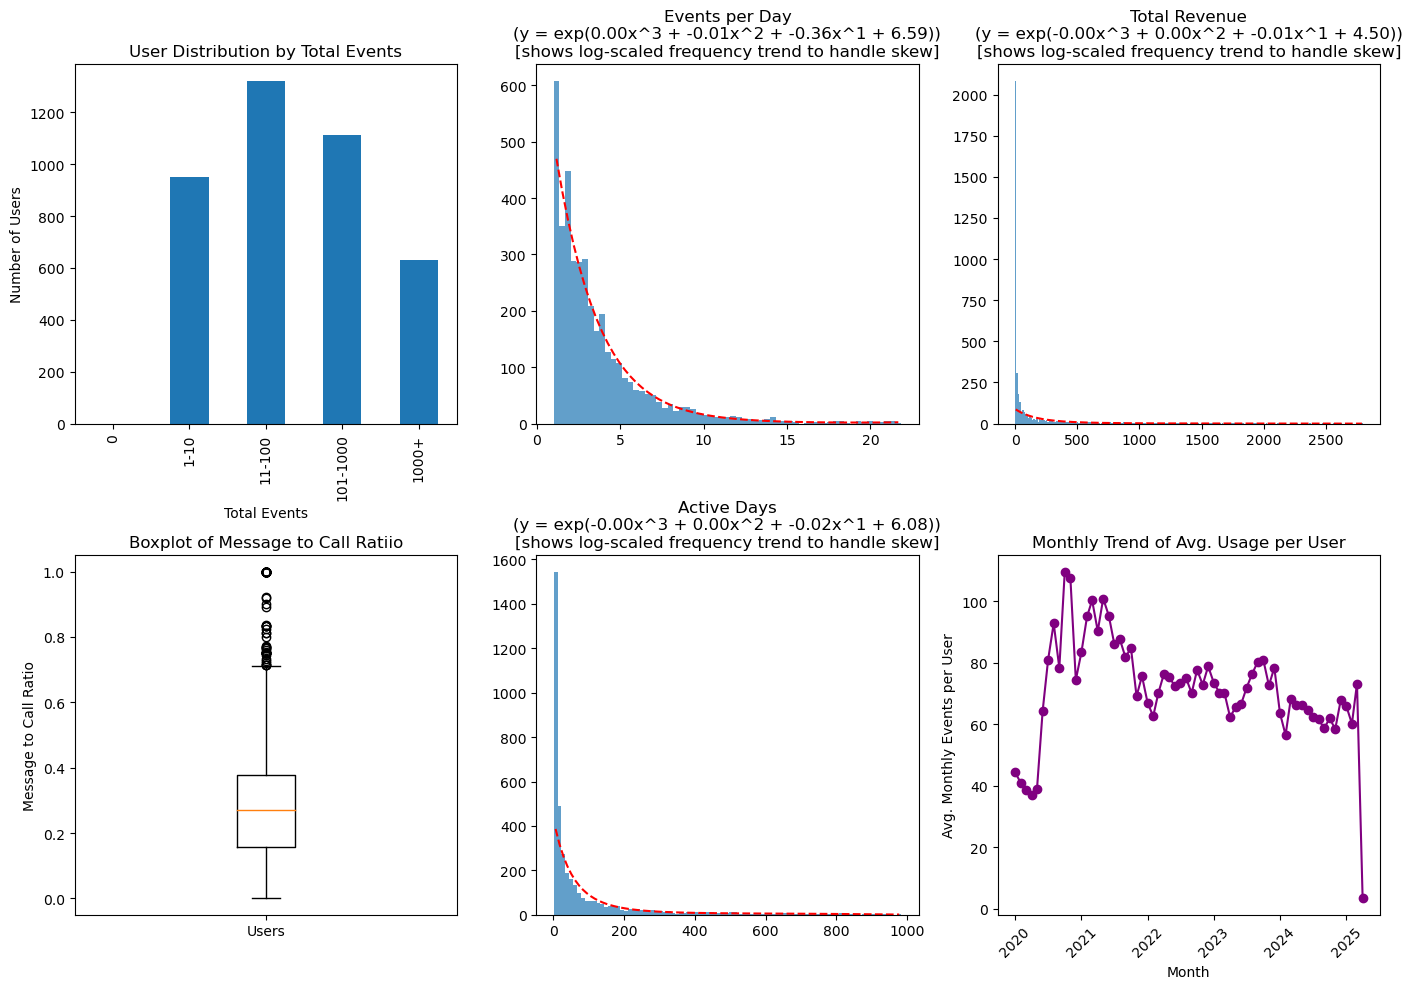

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

# Box/bar plot in the top-left corner
event_bins = pd.cut(user_summary['total_events'], 
                    bins=[-1, 0, 10, 100, 1000, user_summary['total_events'].max()],
                    labels=['0', '1-10', '11-100', '101-1000', '1000+'])

event_bins.value_counts().sort_index().plot.bar(ax=axs[0, 0])
axs[0, 0].set_title('User Distribution by Total Events')
axs[0, 0].set_xlabel('Total Events')
axs[0, 0].set_ylabel('Number of Users')

# Function to auto-bin histograms and plot polynomial curve with equation
def auto_hist(series, ax, title, percentile=0.99, degree=3):
    upper_bound = series.quantile(percentile)
    filtered_series = series[series <= upper_bound]
    counts, bins, _ = ax.hist(filtered_series, bins='auto', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    log_counts = np.log1p(counts)
    coeffs = np.polyfit(bin_centers, log_counts, degree)
    fitted_counts = np.expm1(np.polyval(coeffs, bin_centers))
    poly_eq = "y = exp(" + " + ".join([f"{coeff:.2f}x^{degree - i}" for i, coeff in enumerate(coeffs[:-1])]) + f" + {coeffs[-1]:.2f})"
    ax.plot(bin_centers, fitted_counts, color='red', linestyle='--')
    ax.set_title(f"{title}\n({poly_eq})\n[shows log-scaled frequency trend to handle skew]")

# Histograms with polynomial curve equations
auto_hist(user_summary['events_per_day'], axs[0, 1], 'Events per Day')
auto_hist(user_summary['active_days'], axs[1, 1], 'Active Days')
auto_hist(user_summary['total_revenue'], axs[0, 2], 'Total Revenue')


# Boxplot of Message to Call Ratio
axs[1, 0].boxplot(user_summary['message_call_ratio'], vert=True)
axs[1, 0].set_title('Boxplot of Message to Call Ratiio')
axs[1, 0].set_ylabel('Message to Call Ratio')
axs[1, 0].set_xticklabels(['Users'])

# Monthly trend line of Average Monthly Usage per User
monthly_avg_usage = filtered_logs_df.groupby(filtered_logs_df['month'].dt.to_timestamp())['log_id'].count()
monthly_avg_usage = monthly_avg_usage / filtered_logs_df.groupby(filtered_logs_df['month'].dt.to_timestamp())['account_id'].nunique()

axs[1, 2].plot(monthly_avg_usage.index, monthly_avg_usage.values, marker='o', linestyle='-', color='purple')
axs[1, 2].set_title('Monthly Trend of Avg. Usage per User')
axs[1, 2].set_xlabel('Month')
axs[1, 2].set_ylabel('Avg. Monthly Events per User')
axs[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

*The charts above reveal highly skewed distributions: most users have relatively low activity, while a few have extremely high values. The message-to-call ratio boxplot shows a low median, showing average preferance of calls to texts.*

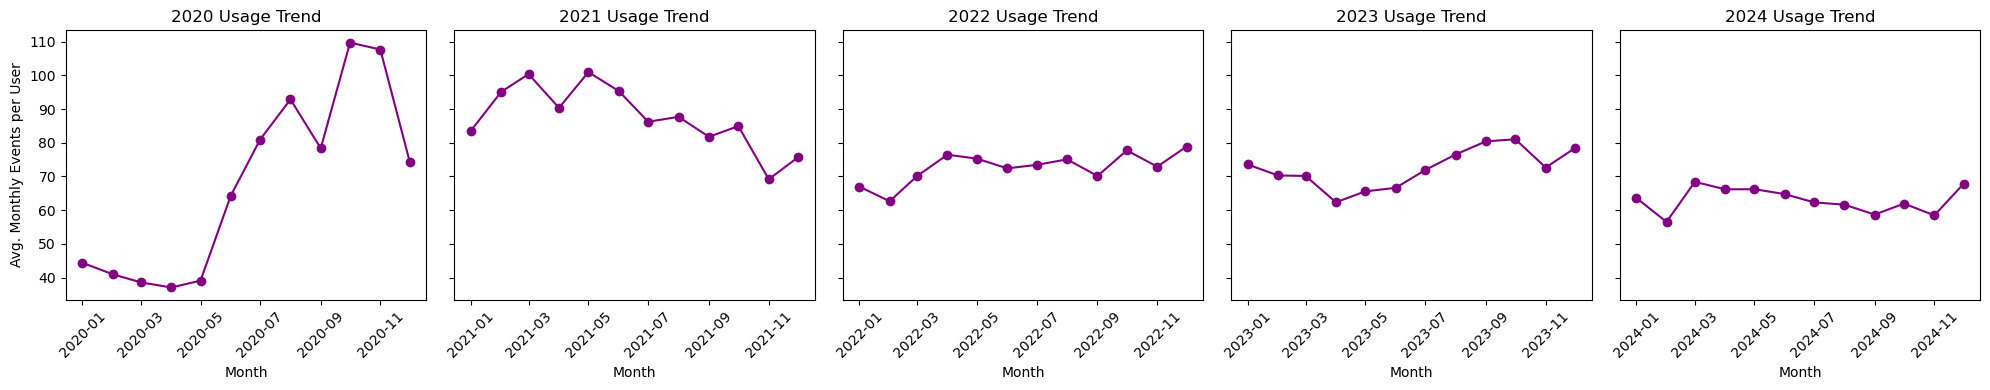

In [6]:
# Prepare data for monthly avg usage per user, clearly filtered by each year
years = range(2020, 2024 + 1)

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, year in enumerate(years):
    yearly_data = filtered_logs_df[filtered_logs_df['date'].dt.year == year]
    monthly_counts = yearly_data.groupby(yearly_data['date'].dt.to_period('M')).agg(
        total_events=('log_id', 'count'),
        active_users=('account_id', 'nunique')
    )
    monthly_counts['avg_monthly_usage'] = monthly_counts['total_events'] / monthly_counts['active_users']
    monthly_counts.index = monthly_counts.index.to_timestamp()

    axs[i].plot(monthly_counts.index, monthly_counts['avg_monthly_usage'], 
                marker='o', linestyle='-', color='purple')
    axs[i].set_title(f'{year} Usage Trend')
    axs[i].set_xlabel('Month')
    if i == 0:
        axs[i].set_ylabel('Avg. Monthly Events per User')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Phase 2: k-Means Segmentation

In Phase 2, we segment user accounts into distinct groups using an unsupervised learning approach. We choose k-means clustering for this task, which will partition the accounts based on their usage metrics into k clusters so users within each cluster have similar behavior. 
<br>
**About k-means Clustering:** k-Means clustering is an algorithm that functions like a digital petri dish. The algorithm places nodes called centoids into a multidimentional space to look for its closest neighbor, eating it up and converting it into its ilk. Then the algorithm recalculates the positions of the centoids and their local cluster, moving the centoid to the center of itself and starting the process again. When some nodes on the edges from the main cluster become too seperated from the pack, they will convert into another cluster group, much like the game of Go. 
<br>
Variance is introduced into the algorithm as depending on where the centoids drop, and how many centoids one selects, it can branch out slightly different. By increasing the number of centoids (k-value), it becomes statistically less variable as K approaches N, though the more centoids you add, the less useful the segmentation will be. 
<br>
You can measure out a Polynomial curve of the value of variance and find the closet number for k by eyeballing the elbow and seeing diminishing reduction of variance. I assume you could just calculate the polynomial curve and calculate the derivitive function to find the tangent and then calculate the closest distance point of K. But it's easier to just eyeball it. You also usually have some idea of how many segments you'll need for customer segmentation, however if you're slightly wrong in estimate, it'll become clear from the elbow graph. 

#### Step 2.1: Choosing the behavioral features and standardizing data

To perform clustering, we first need to decide which features of user behavior to include. Our goal is to segment users based on usage behavior, so we select a set of features that capture different dimensions of how users engage with Corrio SPC. We use the following features for clustering: 
- **[total_events]:** What's the total number of uses (calls/messages)?
- **[events_per_day]:** What's the ratio of uses (numerator) to days of service (denominator)? 
- **[account_age_days]:** How many days of service has the account existed?
- **[total_revenue]:** How much was this account worth over its lifetime?
- **[message_call_ratio]:** What's the ratio of messages to to total calls?
- **[total_overdraw:]** What's the total number of overdraw incidents?
- **[unique_numbers_called] and [unique_numbers_received]:** How many distinct contacts the user has called or received calls/messages from?
<br>
Including this diverse set of features ensures that clustering considers various aspects: overall engagement, intensity, financial value, communication type preference, and network range. All selected feature columns are extracted from our [user_summary] dataframe into a new dataframe [clustering_df]. We fill any mising values with 0 in the case if users have had no calls or messages, changing null to 0. 

**Feature Scaling:** We must also standardize these features before applying k-means. K-means relies on Euclidean distance, so if one feature has a much larger scale than otehrs, it can dominate the distance calculation. To address this, we apply StandardScaler to the feature matrix. StandardScaler transforms each feature ot have a mean of 0 and a standard deviation of 1 (z-scroe normalization). This ensures all features are on a comparable scale and each contributes proportionately to the distance calculations. 

In [115]:
# Choose behavioral features
features = [
    'total_events',
    'events_per_day',
    'account_age_days',
    'active_days',
    'total_revenue',
    'network_size',
    'activedays_accountage_ratio',
    'message_call_ratio'
]
            
clustering_df = user_summary[features].copy().fillna(0)

'''
Standardize values for clustering
The StandardScaler() formula is: z = (x - u) / s
This transforms data to have a mean of 0 and a STD of one, meaning it will standardize the distribution
'''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_df)

#### Step 2.2: Seperating the 'mountain' from the 'rubble'

How many clusters should we create? To answer this, we run k-means for a range of k values and evaluate the inertia for each. We then plot inertia against k in an elbow plot. and "seperate the 'mountain' from the 'rubble'.

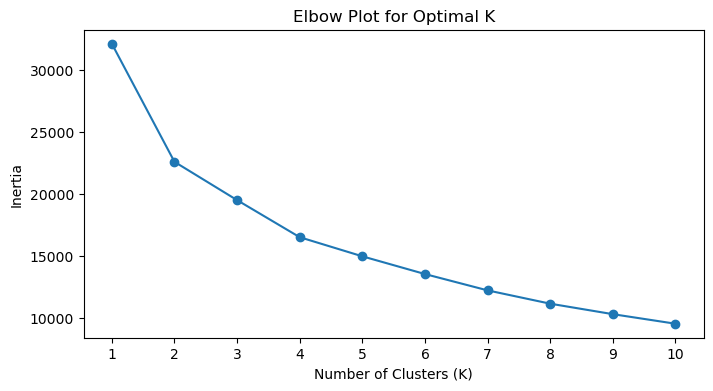

In [116]:
# Try K from 1 to 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(list(K_range))
plt.show()

*Looking at the elbow plot, it's rather ambiguous. Given that, I played around and found that 5 worked the best when I validated the clusters in a later step. So clearly not a perfect fool proof method for finding k, but still a useful tool.*

#### Step 2.3: Applying k-means and basic cluster metrics 

Having determined k = 4, we now fit the k-means algorithm on the scaled data to actually segment the users. We use KMeans(n_clusters=3, random_state=42) from scikit-learn to ensure reproducibility (the random_state fixes the initial centroid seeds). Each user account in our dataset is assigned a cluster label (0 through 3) indicating which of the 4 clusters it belongs to. We add this cluster label to our [user_summary] dataframe for analysis.


Next, we compute some basic metrics for each cluster to interpret them. We aggregate the data by cluster to get the average value of each feature within that cluster, and also count how many users fall into each cluster.

In [123]:
# Choose k based on elbow plot
k_value = 4
kmeans = KMeans(n_clusters=k_value, random_state=42)
user_summary['cluster'] = kmeans.fit_predict(X_scaled)

# Quick look at cluster assignments
user_summary[['account_id', 'cluster']].head()

,account_id,cluster
0,001b48189af3f8cd5fd22feb8b65f170,0
1,001b48189af3f8cd5fd22feb8bda3e24,0
2,001b48189af3f8cd5fd22feb8bfee033,0
3,003bc62c5c8f8ee4d31d18c7bb0c8227,3
4,003bc62c5c8f8ee4d31d18c7bb0e0850,0


In [124]:
# Descriptive stats per cluster
cluster_profile = user_summary.groupby('cluster')[features].mean().round(2)
cluster_profile['user_count'] = user_summary['cluster'].value_counts().sort_index()
cluster_profile

,total_events,events_per_day,account_age_days,active_days,total_revenue,network_size,activedays_accountage_ratio,message_call_ratio,user_count
cluster,,,,,,,,,
0,161.48,2.96,342.25,42.78,39.09,13.45,0.14,0.26,2777
1,13270.40,17.41,1243.95,953.37,4598.52,139.65,0.79,0.35,43
2,3038.18,6.75,997.12,508.06,856.39,66.64,0.54,0.30,428
3,383.93,5.34,72.13,50.19,121.23,10.64,0.93,0.31,765


In [ ]:
#for testing purposes
# Print every node (user) grouped by cluster
for cluster, cluster_df in user_summary.groupby('cluster'):
    print(f"\nCluster {cluster} (Total users: {len(cluster_df)}):")
    display(cluster_df[['account_id'] + features].reset_index(drop=True))


In [ ]:
#for testing purposes
account_id = ''

single_user_summary = user_summary[user_summary['account_id'] == account_id]

# Display the result
display(single_user_summary.T)

#### Step 2.5: Show me the money

Next, We'll examine the financial aspect of these segments by examining the distribution of total revenue within each cluster. We use a boxplot via Seaborn to visualize the spread of [total_revenue] for users in each cluster. This provides a sense of the variation in user value within each segment, not just the mean.

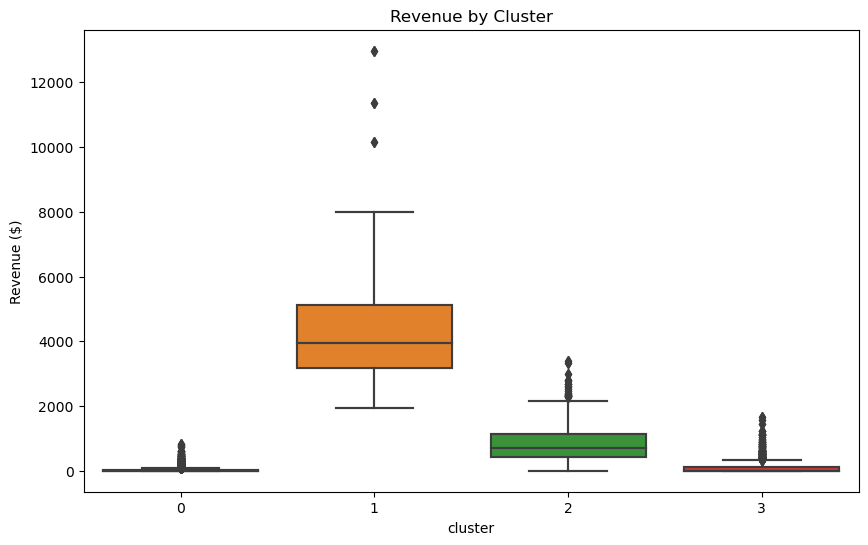

In [125]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=user_summary, x='cluster', y='total_revenue')
sns.boxplot(data=user_summary, x='cluster', y='total_revenue')
plt.title("Revenue by Cluster")

# Modify the y-axis label to include a dollar sign
ax.set_ylabel("Revenue ($)")  # Or use ax.set_ylabel("Cost (USD)")

plt.show()

From this box plot, we confirm a key business insight: a very small fraction of users (Cluster 4, and to a lesser extent Cluster 3) contribute the majority of revenue, whereas the bulk of the user base (Clusters 0, 1, 2) have much lower individual contributions. This is a classic Pareto-like scenario. The boxplot visualization helps validate that our clustering meaningfully separated users by value. It also highlights potential targets for strategy: for instance, clusters 0 and 1 might be targets for upsell or re-engagement (since they’re low revenue currently), whereas clusters 3 and 4 might warrant retention efforts (since they are high revenue generators).

#### Step 2.6: Dimensionality reduction for cluster validation

We apply Principal Component Analysis (PCA) to reduce the high-dimensional feature space to 2 principal components for visualization. If the clusters identified by k-means are meaningful, they should also appear as distinct groupings in the PCA-transformed space.

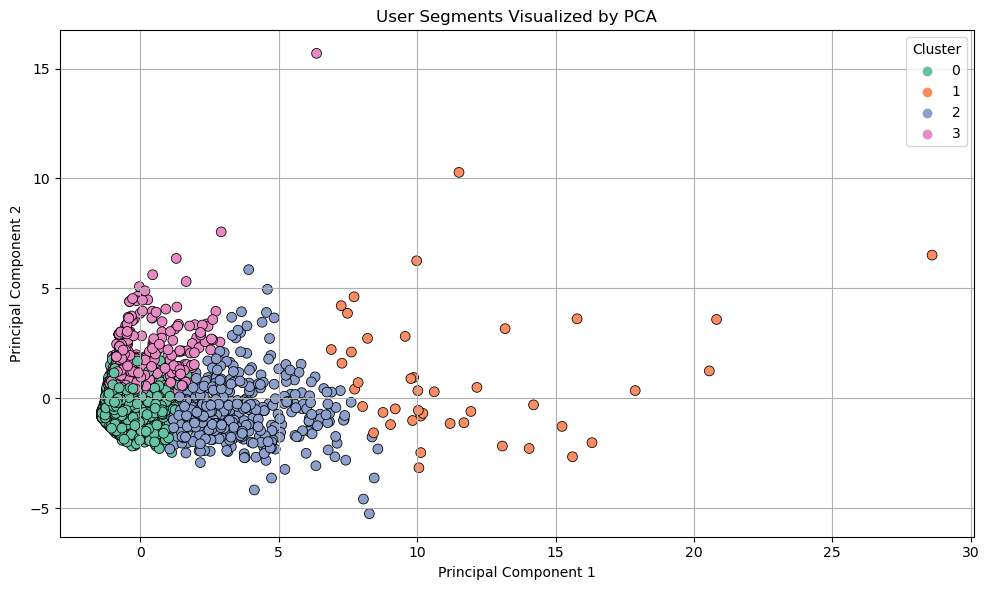

In [126]:
# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add components to user_summary
user_summary['pca_x'] = pca_components[:, 0]
user_summary['pca_y'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca_x', y='pca_y',
    hue='cluster',
    data=user_summary,
    palette='Set2',
    s=50, edgecolor='black'
)
plt.title('User Segments Visualized by PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

*The PCA visualization supports our clustering results: we see distinct groupings of accounts corresponding to our segments, especially highlighting the separation of heavy users from light users. The clusters do not completely overlap, which means the segmentation is meaningful. This builds confidence that the chosen features and k-means algorithm successfully identified natural groupings in user behavior.*

In [ ]:
### Phase 3:** Other Graphs & Metrics

#### Step 2.7: more metrics

In [127]:
# Compute average metrics and rename total_revenue to average_revenue
cluster_summary = user_summary.groupby('cluster')[['total_events', 'events_per_day', 'active_days', 'total_revenue']].mean().round()
cluster_summary = cluster_summary.rename(columns={'total_revenue': 'average_revenue'})

# Add total revenue as a new column
cluster_summary['total_revenue'] = user_summary.groupby('cluster')['total_revenue'].sum()

# Display the result
cluster_summary

,total_events,events_per_day,active_days,average_revenue,total_revenue
cluster,,,,,
0,161.0,3.0,43.0,39.0,108561.0250
1,13270.0,17.0,953.0,4599.0,197736.2955
2,3038.0,7.0,508.0,856.0,366534.9905
3,384.0,5.0,50.0,121.0,92740.1190


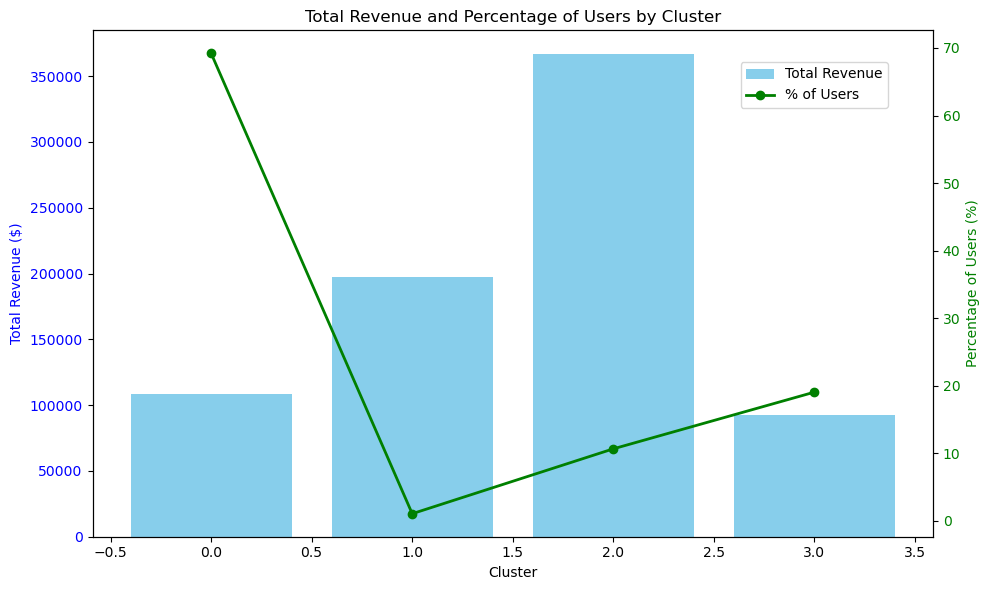

In [128]:
# Calculate cluster summary
cluster_summary = user_summary.groupby('cluster').agg(
    total_revenue=('total_revenue', 'sum'),
    user_count=('cluster', 'count')
).reset_index()

# Calculate percentage of users per cluster
cluster_summary['user_percentage'] = (
    cluster_summary['user_count'] / cluster_summary['user_count'].sum() * 100
).round(2)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for total revenue
ax1.bar(cluster_summary['cluster'], cluster_summary['total_revenue'], color='skyblue', label='Total Revenue')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total Revenue ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis for user percentage
ax2 = ax1.twinx()
ax2.plot(cluster_summary['cluster'], cluster_summary['user_percentage'], color='green', marker='o', linestyle='-', linewidth=2, label='% of Users')
ax2.set_ylabel('Percentage of Users (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Titles and legend
plt.title('Total Revenue and Percentage of Users by Cluster')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()

**Cluster 2:** generates the highest total revenue despite being only ~10% of users

**Cluster 0:** comprises the largest share of users (~70%), but contributes relatively less total revenue. 

#### Step 2.6: Distribution of User Revenue within Segments

In this step, we aim to visualize and better understand the distribution of total revenue contributed by individual users within each identified cluster. We will plot histograms segmented by user clusters to expose underlying patterns in revenue distribution, highlighting variations such as long-tailed distributions or distinct revenue peaks that summary statistics alone might obscure. 

This approach is selected to illuminate whether clusters are primarily driven by a small subset of high-value users or exhibit a more balanced revenue contribution across members. Insights gained from this step will help us refine targeting and better understand segment-specific revenue potential.

#### Step 2.7: Distribution of User Revenues per Cluster

How does user spending very within each cluster?

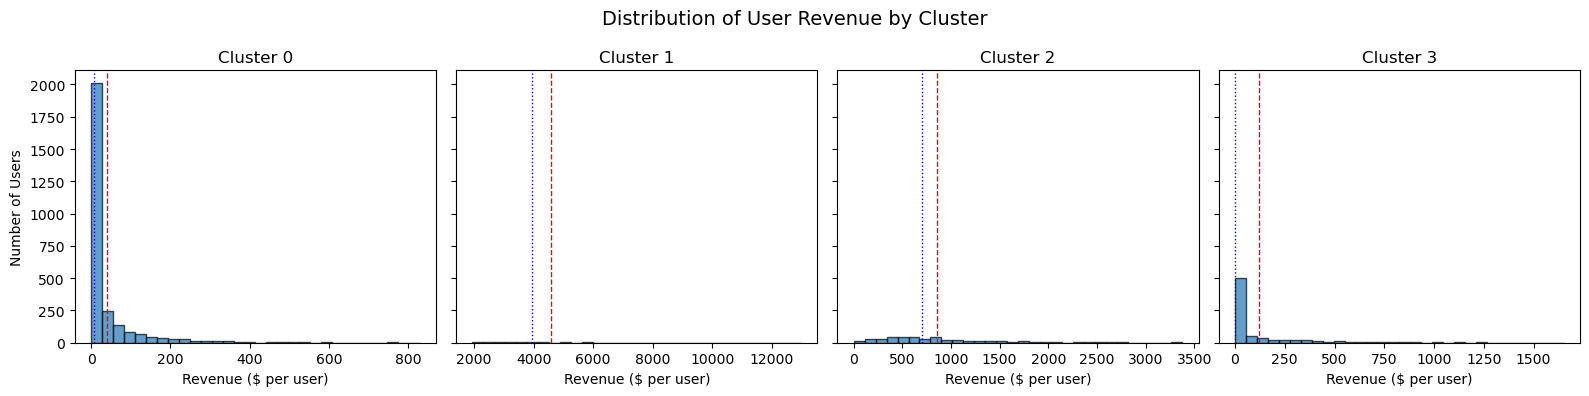

In [129]:
# Plot histograms of user revenue for each cluster to show distribution within segments
clusters = sorted(user_summary['cluster'].unique())                # List of cluster labels (e.g., 0,1,2,...)
n_clusters = len(clusters)
fig, axs = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axs[i]
    # Filter revenue data for the current cluster
    revenues = user_summary[user_summary['cluster'] == cluster]['total_revenue']
    ax.hist(revenues, bins=30, color='C0', alpha=0.7, edgecolor='black')
    ax.set_title(f"Cluster {cluster}")                            # Title indicating cluster number
    ax.set_xlabel("Revenue ($ per user)")                         # X-axis label for revenue in dollars
    if i == 0:
        ax.set_ylabel("Number of Users")                          # Y-axis label on the first subplot for user count
    # Optional: indicate mean or median on the histogram for reference
    ax.axvline(revenues.mean(), color='red', linestyle='dashed', linewidth=1)
    ax.axvline(revenues.median(), color='blue', linestyle='dotted', linewidth=1)

plt.suptitle("Distribution of User Revenue by Cluster", fontsize=14)
plt.tight_layout()
plt.show()

pretty much what we expected: revenue generating clusters have highly skewed distributions, with majority generating minimal revenue and a few high-spending outliers. 

#### Step 2.8: Revenue Contribution by Deciles per Cluster
We hypothesize that user clusters differ significantly in their revenue distribution, with certain segments relying heavily on a small subset of high-value users, while others exhibit a more evenly distributed revenue pattern.

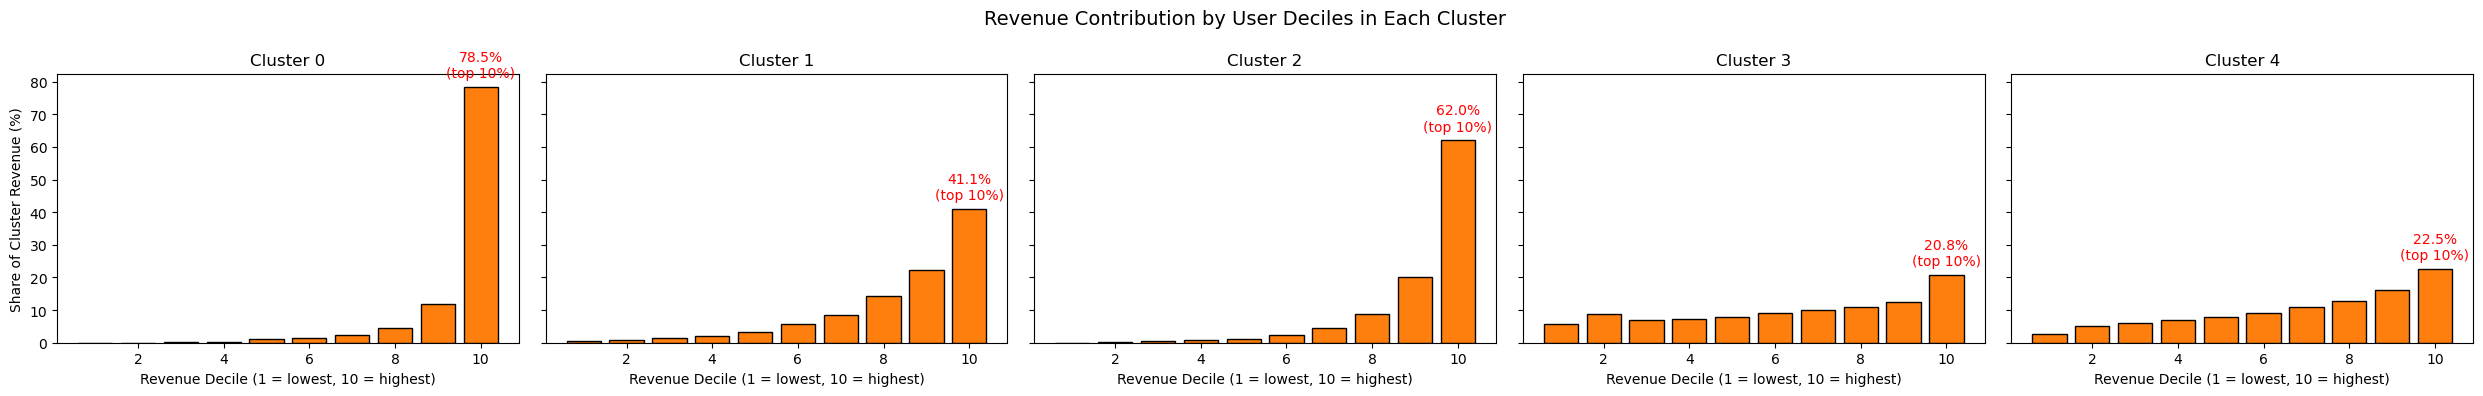

In [24]:
# Pareto analysis: For each cluster, compute revenue share by decile and plot as a bar chart
clusters = sorted(user_summary['cluster'].unique())
n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 4), sharey=True)

for i, cluster in enumerate(clusters):
    ax = axes[i]
    cluster_revs = user_summary[user_summary['cluster'] == cluster]['total_revenue'].values
    total_rev = cluster_revs.sum()
    # Sort users in this cluster by revenue (ascending)
    sorted_revs = np.sort(cluster_revs)  
    # Split into 10 roughly equal groups (deciles)
    deciles = np.array_split(sorted_revs, 10)  
    # Calculate share of total revenue each decile contributes
    decile_shares = [(d.sum() / total_rev) * 100 for d in deciles]  
    # Plot bar chart for this cluster's decile shares
    ax.bar(range(1, 11), decile_shares, color='C1', edgecolor='black')
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Revenue Decile (1 = lowest, 10 = highest)")
    if i == 0:
        ax.set_ylabel("Share of Cluster Revenue (%)")
    # Annotate top decile percentage for emphasis
    top_decile_pct = decile_shares[-1]
    ax.text(10, top_decile_pct + 3, f"{top_decile_pct:.1f}%\n(top 10%)", ha='center', color='red')

plt.suptitle("Revenue Contribution by User Deciles in Each Cluster", fontsize=14)
plt.tight_layout()
plt.show()

The decile breakdown chart shows the uneven distribution of revenue across user clusters.

**Cluster 0:** shows significant revenue concentration, with the top 10% of users generating approximately 78.5% of the segment’s revenue, highlighting a strong dependence on these key users. 

**Cluster 2:**  shows high revenue concentration (62.0% from top decile)

**Clusters 1, 3, and 4:** shows a more balanced distribution (around 41.1%, 20.8%, and 22.5% respectively), indicating broader revenue contributions across users. 

**Hypothesis:** if we target mid-tier users with tailored promotions or enhanced features, some of them could be elevated into the top decile, thereby reducing revenue concentration risk. 

If validated, it means we can grow revenue organically within a segment by nurturing more “near-heavy” users into true heavy users, all while making the segment’s revenue stream more resilient. 

#### Step 2.9: Correlation between User Network Size and Revenue
We hypothesize that users with larger communication networks (more unique contacts) generate higher revenues, and that distinct user segments differ significantly in how effectively they monetize their network size.

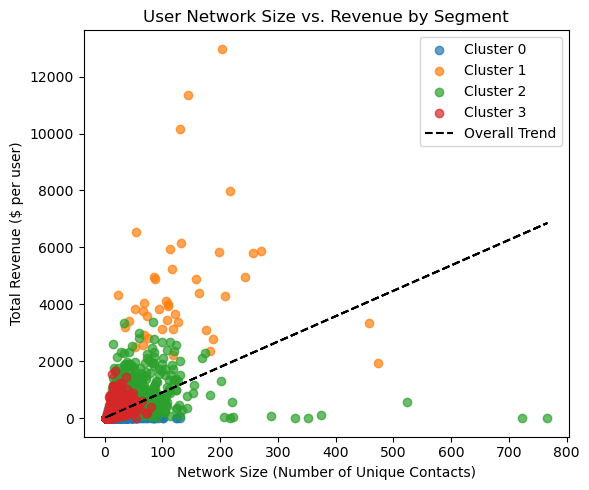

Overall correlation between network size and revenue: 0.49

T-test comparing network size between clusters 1 and 2:
  t-statistic: 4.90, p-value: 0.0000
Statistically significant difference in network sizes between these two clusters.


In [133]:
# Scatter plot of user network size vs. total revenue, colored by cluster to show segment differences
plt.figure(figsize=(6,5))
for cluster in clusters:
    subset = user_summary[user_summary['cluster'] == cluster]
    plt.scatter(subset['network_size'], subset['total_revenue'], 
                label=f"Cluster {cluster}", alpha=0.7)
# Add a trend line for overall correlation (optional)
m, b = np.polyfit(user_summary['network_size'], user_summary['total_revenue'], 1)
plt.plot(user_summary['network_size'], m*user_summary['network_size'] + b, 
         color='black', linestyle='--', label='Overall Trend')

plt.title("User Network Size vs. Revenue by Segment")
plt.xlabel("Network Size (Number of Unique Contacts)")
plt.ylabel("Total Revenue ($ per user)")
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and display overall correlation coefficient
corr = user_summary['network_size'].corr(user_summary['total_revenue'])
print(f"Overall correlation between network size and revenue: {corr:.2f}")

# === Perform T-test between the two highest revenue-generating clusters ===

# Identify top two clusters based on mean revenue
cluster_revenues = user_summary.groupby('cluster')['total_revenue'].mean()
top_two_clusters = cluster_revenues.sort_values(ascending=False).index[:2]

# Extract network sizes for these clusters
network_sizes_cluster1 = user_summary[user_summary['cluster'] == top_two_clusters[0]]['network_size']
network_sizes_cluster2 = user_summary[user_summary['cluster'] == top_two_clusters[1]]['network_size']

# Perform independent samples t-test
t_stat, p_val = stats.ttest_ind(network_sizes_cluster1, network_sizes_cluster2, equal_var=False)

print(f"\nT-test comparing network size between clusters {top_two_clusters[0]} and {top_two_clusters[1]}:")
print(f"  t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

# Interpret results
if p_val < 0.05:
    print("Statistically significant difference in network sizes between these two clusters.")
else:
    print("No statistically significant difference in network sizes between these two clusters.")

The scatter plot shows a moderate positive relationship between user network size and revenue, indicating a positive correlation. Users with larger networks typically generate higher revenues, as shown by the upward trend line.

Strategically, Corrio SPC should consider network size as one important factor but not rely solely on it when targeting users for increased revenue growth

**Hypothesis:** if we actively help or incentivize users to expand their network of contacts on the platform, their revenue will increase as a result. 

#### Step 4.1: Average Monthly Usage per User by Cluster Over Time

We hypothesize that distinct user segments exhibit different monthly usage patterns over time, with some clusters showing stable engagement, others seasonal fluctuations, and high-value segments potentially experiencing notable engagement changes.

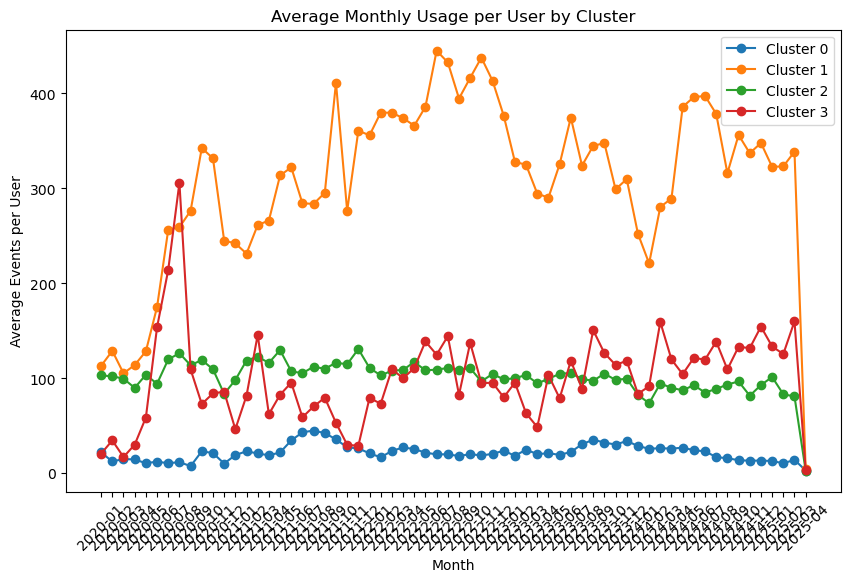

In [120]:
# Prepare monthly usage data per cluster
monthly_events = filtered_logs_df.groupby(['account_id', 'month']).size().reset_index(name='events_count')
monthly_events = monthly_events.merge(user_summary[['account_id', 'cluster']], on='account_id', how='left')
monthly_usage = monthly_events.groupby(['cluster', 'month'])['events_count'].mean().reset_index(name='avg_usage_per_user')

# Line chart: average monthly usage per user for each cluster over time
clusters = sorted(monthly_usage['cluster'].unique())
plt.figure(figsize=(10,6))
for cluster in clusters:
    cluster_data = monthly_usage[monthly_usage['cluster'] == cluster].sort_values('month')
    plt.plot(cluster_data['month'].astype(str), cluster_data['avg_usage_per_user'], marker='o', label=f"Cluster {cluster}")
plt.title('Average Monthly Usage per User by Cluster')
plt.xlabel('Month')
plt.ylabel('Average Events per User')
plt.xticks(rotation=45)
plt.legend()
plt.show()

This time-series visualization clearly shows distinct monthly usage trends among clusters. 

**Cluster 1:** (orange) consistently has the highest engagement, peaking mid-period, then experiencing a notable drop at the end, suggesting possible churn or an external factor reducing usage

**Cluster 3:** (red) shows high but volatile monthly usage, indicating seasonality or event-driven engagement

**Clusters 0 and 2:** (blue and green) maintain relatively stable but low-to-moderate activity throughout the period, reflecting consistent but lower-intensity engagement

These distinct patterns can guide targeted strategies: 
- Cluster 1 may require re-engagement initiatives
- Cluster 3 could benefit from seasonal promotions 
- Clusters 0 and 2 might be targets for steady engagement or upsell efforts